---
title: "Sentiment Analysis with NLTK and Hugging Face Transformers"
author: "Daniel J Smith"
date: "2024-01-23"
categories: [Python, ML, NLP, NLTK, Transformers]
title-block-banner: false
jupyter: python3
image: 'preview.png'
draft: false
description: "Sentiment analysis is performed on a dataset of Amazon reviews using NLTK's VADER and a RoBERTa-base model from Hugging Face."
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
color_pal = sns.color_palette("mako")

from wordcloud import WordCloud
from tqdm.notebook import tqdm  #Progress Bar

from bs4 import BeautifulSoup
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.feature_extraction.text import CountVectorizer
from scipy.special import softmax

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch._utils")

In [2]:
print("Python version:")
!python --version

Python version:
Python 3.11.4


Sentiment analysis is a standard application of natural language processing (NLP) in which a machine learning algorithm is trained to classify text as having either positive, negative or neutral emotional tone.

As a subfield of NLP, sentiment analysis is closely related to computational linguistics. Sentiment analysis has also been found to be useful in the implementation of recommender systems, in which an automated understanding of the emotional content of reviews proves to be crucial for accurate and personalized content recommendation.

In this post sentiment analysis is performed on a dataset of Amazon reviews using both NLTK's VADER sentiment analysis tool and the Hugging Face transformer-based model RoBERTa.

<a name="data"></a>

# Data

The data can be downloaded from [Kaggle](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/data) and consists of 568,454 Amazon reviews of of 74,258 fine foods products by 256,059 users between Oct 1999 - Oct 2012. This post is based upon a [Youtube video](https://www.youtube.com/watch?v=QpzMWQvxXWk) by [Rob Mulla](https://www.youtube.com/@robmulla).

In [47]:
df = pd.read_csv('Reviews.csv')

In [48]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [49]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [50]:
df.shape

(568454, 10)

Working with the over half a million reviews directly would be computationally expensive. In the interests of time we look only at the first 1000 reviews. The techniques used would not change when working with the full dataset.

In [51]:
df = df.head(1000)

<a name="eda"></a>

## EDA

Text(0, 0.5, 'Number of Reviews')

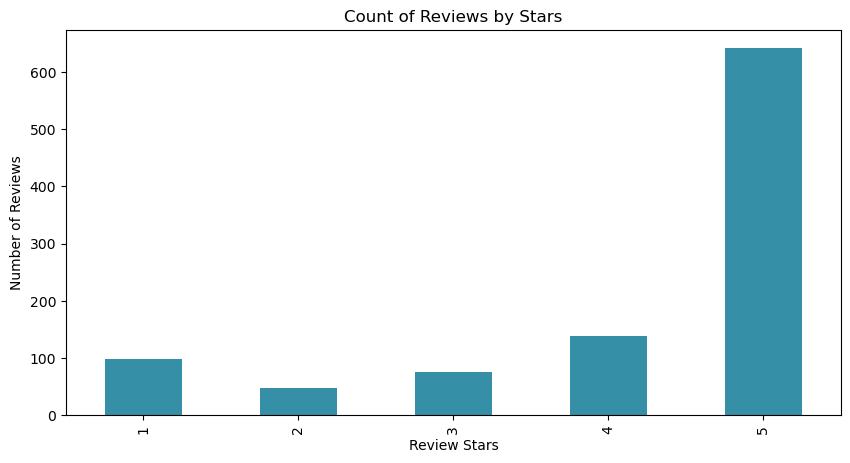

In [52]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10,5),
          color = color_pal[3])
ax.set_xlabel('Review Stars')
ax.set_ylabel('Number of Reviews')

(-0.5, 799.5, 399.5, -0.5)

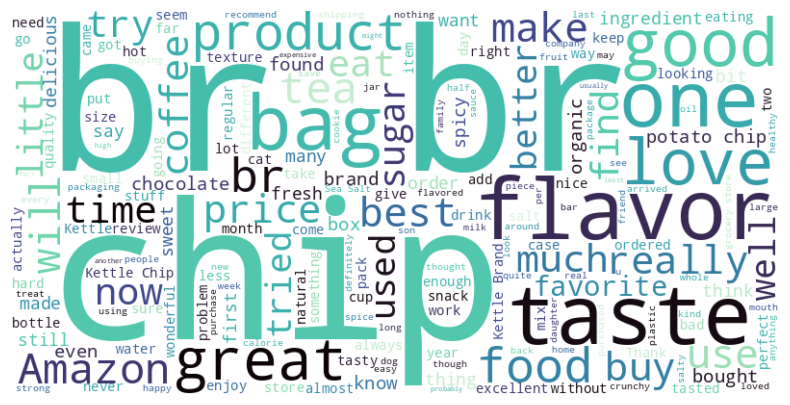

In [53]:
# Generating a worldcloud of all the text in the 'Text' column of the dataframe

text = ' '.join(df['Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='mako').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

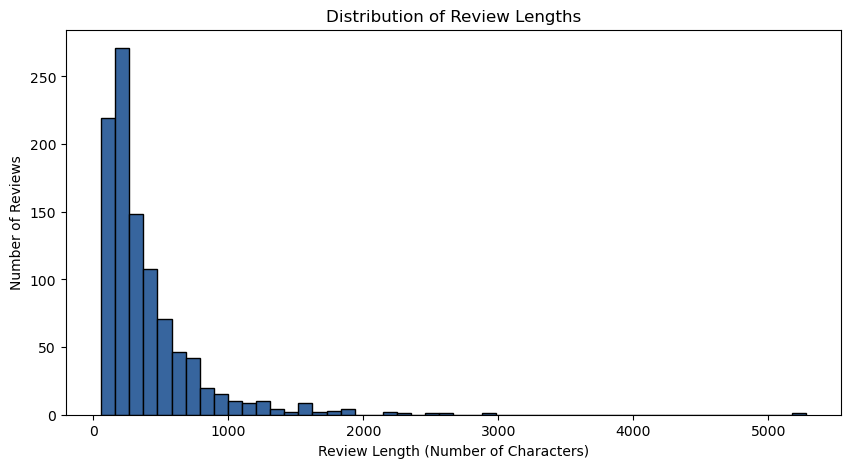

In [54]:
df['ReviewLength'] = df['Text'].apply(len)

plt.figure(figsize=(10, 5))
plt.hist(df['ReviewLength'], bins=50, color=color_pal[2], edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (Number of Characters)')
plt.ylabel('Number of Reviews')
plt.show()

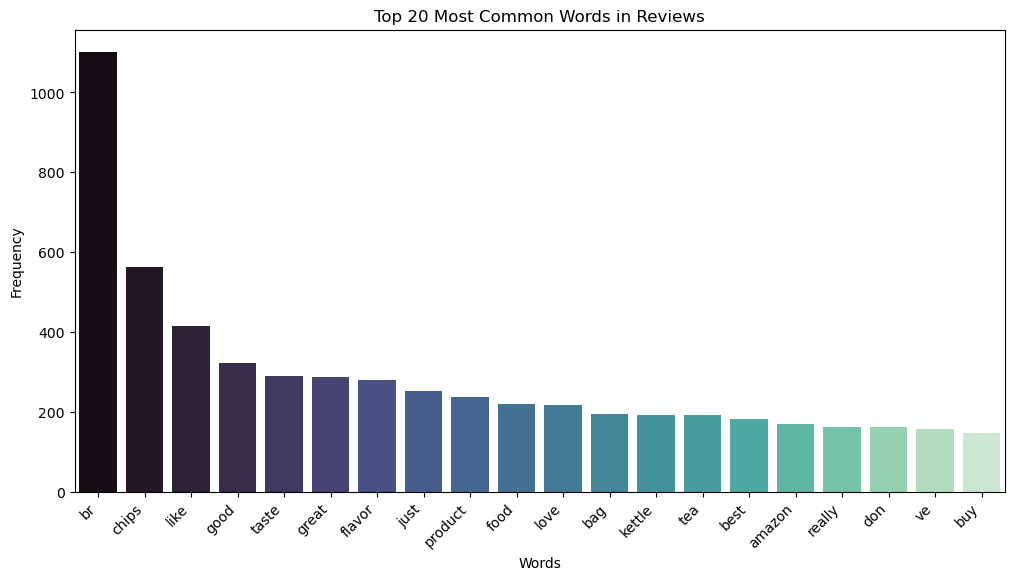

In [55]:
vectorizer = CountVectorizer(stop_words='english', max_features=20)
word_matrix = vectorizer.fit_transform(df['Text'])
word_frequency = word_matrix.sum(axis=0)

words = vectorizer.get_feature_names_out()
counts = word_frequency.A1

sorted_indices = counts.argsort()[::-1]
words = [words[i] for i in sorted_indices]
counts = counts[sorted_indices]

plt.figure(figsize=(12, 6))
sns.barplot(x=words, y=counts, palette='mako')
plt.title('Top 20 Most Common Words in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right');

## Cleaning Text

"br" is such a common word beacuse it is present in many of the reviews as a html tag: `<br></br>`

We can fix this using the BeautifulSoup library.

In [56]:
warnings.filterwarnings("ignore", category=UserWarning)

def clean_text(text):
    # Remove HTML tags
    soup = BeautifulSoup(str(text), 'html.parser')
    cleaned_text = soup.get_text()

    return cleaned_text

In [57]:
df['Text'] = df['Text'].apply(clean_text)

(-0.5, 799.5, 399.5, -0.5)

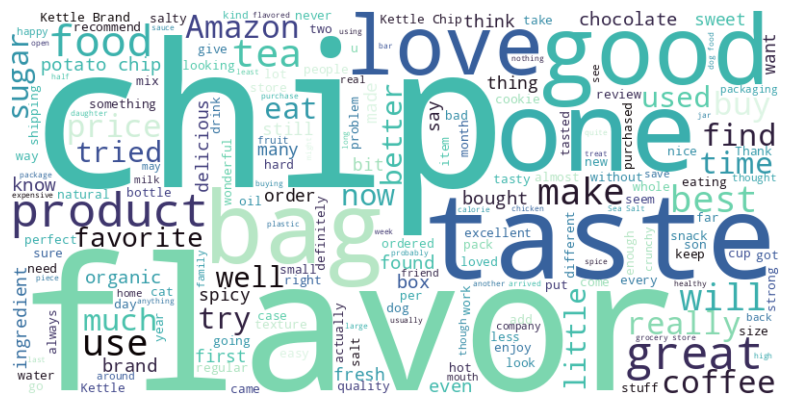

In [58]:
# Generating a worldcloud of all the text in the 'Text' column of the dataframe

text = ' '.join(df['Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='mako').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

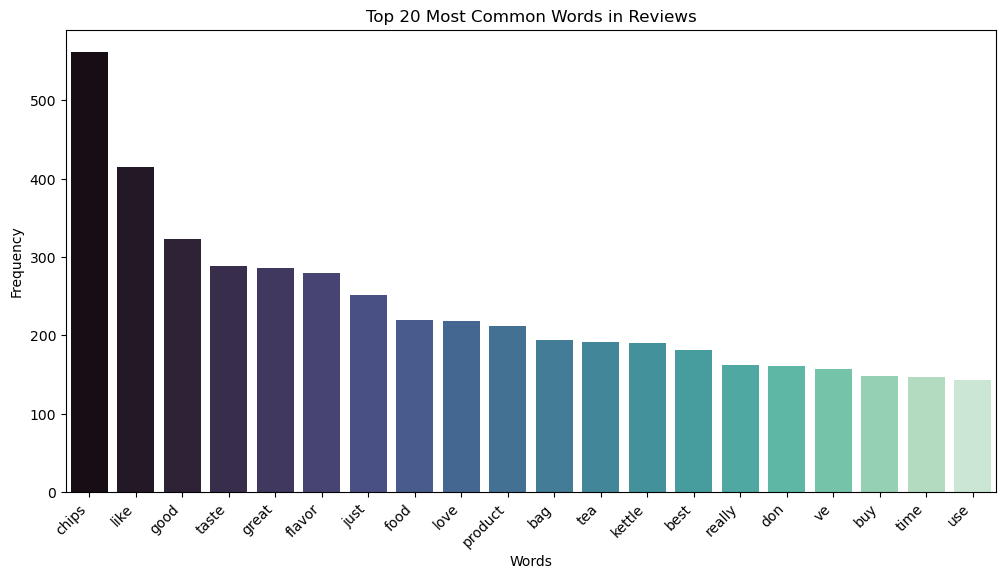

In [59]:
vectorizer = CountVectorizer(stop_words='english', max_features=20)
word_matrix = vectorizer.fit_transform(df['Text'])
word_frequency = word_matrix.sum(axis=0)

words = vectorizer.get_feature_names_out()
counts = word_frequency.A1

sorted_indices = counts.argsort()[::-1]
words = [words[i] for i in sorted_indices]
counts = counts[sorted_indices]

plt.figure(figsize=(12, 6))
sns.barplot(x=words, y=counts, palette='mako')
plt.title('Top 20 Most Common Words in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right');

<a name="vader"></a>

# Sentiment Analysis with VADER

NLTK's [VADER](https://www.nltk.org/api/nltk.sentiment.vader.html), short for "Valence Aware Dictionary and sEntiment Reasoner," is a pre-built sentiment analysis tool designed for analyzing the sentiment of text data, particularly in the context of natural language processing tasks.

## Basic NLTK

NLTK stands for [Natural Language Toolkit](https://www.nltk.org/). It is a comprehensive library in Python that provides tools and resources for working text data. NLTK includes various modules and packages for tasks such as tokenization, stemming, tagging, parsing, and sentiment analysis, making it a valuable resource for NLP tasks.

In [60]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [61]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [62]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [63]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## SentimentIntensityAnalyzer

`SentimentIntensityAnalyzer` is a class in the NLTK library's VADER module. 
It is designed for sentiment analysis and provides a pre-trained machine learning model to assess the sentiment of a piece of text by analyzing the 
intensity of positive, negative, and neutral sentiments. 

This uses a "bag of words" approach in which:
1. Stop words are removed
2. Each word is scored, and combined to give a total score

In [64]:
sia = SentimentIntensityAnalyzer()

In [65]:
sia.polarity_scores('This is a positive sentence.')

{'neg': 0.0, 'neu': 0.29, 'pos': 0.71, 'compound': 0.5994}

In [66]:
sia.polarity_scores('This is a negative sentence.')

{'neg': 0.529, 'neu': 0.286, 'pos': 0.186, 'compound': -0.5267}

In [67]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [68]:
sia.polarity_scores('I hate this product')

{'neg': 0.649, 'neu': 0.351, 'pos': 0.0, 'compound': -0.5719}

In [69]:
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [70]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [71]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [72]:
# Convert res to a dataframe
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df,how='left')

In [73]:
# Now we have sentiment score and metadata
vaders

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ReviewLength
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,263
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,190
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,509
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,219
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,0.026,0.716,0.257,0.9788,B006F2NYI2,A1D3F6UI1RTXO0,Swopes,1,1,5,1331856000,Hot & Flavorful,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,477
996,997,0.000,0.786,0.214,0.9309,B006F2NYI2,AF50D40Y85TV3,Mike A.,1,1,5,1328140800,Great Hot Sauce and people who run it!,"Man what can i say, this salsa is the bomb!! i...",305
997,998,0.000,0.673,0.327,0.9634,B006F2NYI2,A3G313KLWDG3PW,kefka82,1,1,5,1324252800,this sauce is the shiznit,this sauce is so good with just about anything...,265
998,999,0.063,0.874,0.062,-0.0129,B006F2NYI2,A3NIDDT7E7JIFW,V. B. Brookshaw,1,2,1,1336089600,Not Hot,Not hot at all. Like the other low star review...,280


## Plotting VADER Results

Text(0.5, 1.0, 'Compound Score by Amazon Star Review')

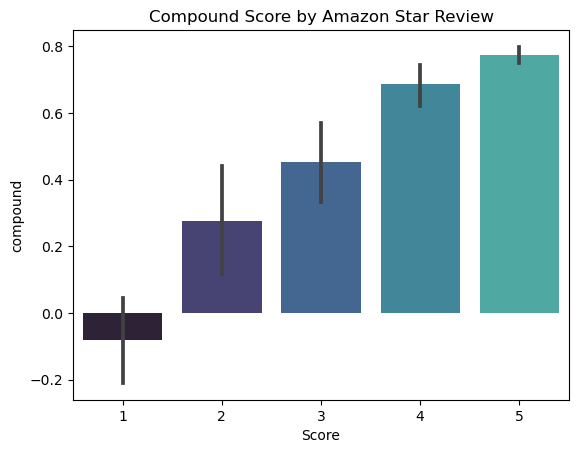

In [74]:
ax = sns.barplot(data=vaders,
                 x = 'Score',
                 y = 'compound',
                 palette = color_pal)
ax.set_title('Compound Score by Amazon Star Review')

Unsuprisingly there is a positive correlation between review score (stars out of five) and the compound score from VADER.

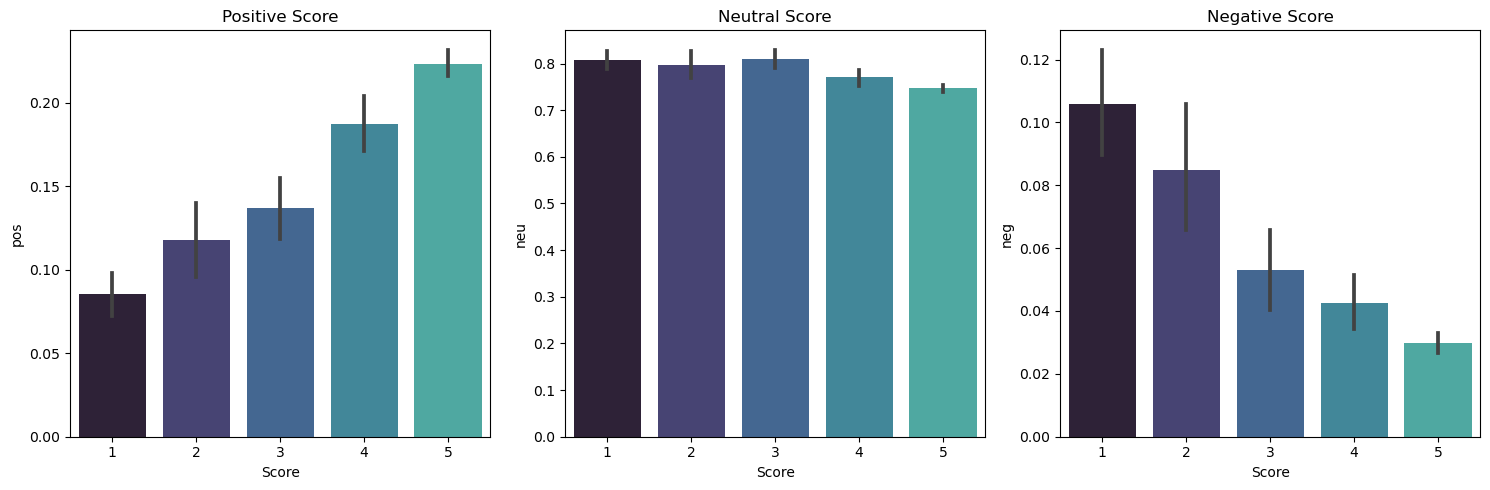

In [75]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data=vaders, x = 'Score', y = 'pos', ax=axs[0], palette = color_pal)
axs[0].set_title('Positive Score')
sns.barplot(data=vaders, x = 'Score', y = 'neu', ax=axs[1], palette = color_pal)
axs[1].set_title('Neutral Score')
sns.barplot(data=vaders, x = 'Score', y = 'neg', ax=axs[2], palette = color_pal)
axs[2].set_title('Negative Score')
plt.tight_layout()

<a name="rob"></a>

# Sentiment Analysis with a Hugging Face Transformer (RoBERTa)

- Hugging Face is an AI research organization that has contributed significantly to the development of transformer-based models for NLP. The Hugging Face Transformers library is a popular open-source library that provides pre-trained transformer models, including RoBERTa.
- RoBERTa is a robustly optimized transformer-based natural language processing model developed by Facebook AI Research (FAIR), designed as an extension and enhancement of the BERT architecture.
- The powerful transformer model acounts not only for the words but also the context related to other words, a fact that makes RoBERTa more expressive than VADER.


The specific model we use here can be found at https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment

It is a RoBERTa-base model pre-trained on a dataset of over 50 million tweets and fine-tuned for sentiment analysis. This is an example of *transfer learning*, the application to a task of a ML model that has been pre-trained on data for another closely related task for which data is more easily gathered.

In [76]:
task = "sentiment"
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [77]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [78]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy() # Save scores as NumPy array
scores = softmax(scores)

scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}

In [79]:
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687459, 'roberta_pos': 0.0029573692}


Roberta is far more certain that the example review is negative in sentiment than the VADER model. I would agree.

In [80]:
def polarity_scores_roberta(example):
    '''
    Applies the Roberta model to extract polarity scores for an inputted review
    
    Arguments:
    example - A string representing the text attached to an amazon review
    
    Returns:
    scores_dict - A dictionary containing the negative/neutral/positive scores
    '''
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [81]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try: 
        text = row['Text']
        myid = row['Id']

        vader_result = sia.polarity_scores(text)

        # Rename the keys for the VADER results for consistency
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value

        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result} #Combine dictionaries
        res[myid] = both
    except RuntimeError:        #Avoids the loop breaking when a review cannot be parsed by the model
        print(f'Broke for id {myid}')    

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863


In [82]:
both

{'vader_neg': 0.032,
 'vader_neu': 0.928,
 'vader_pos': 0.041,
 'vader_compound': -0.1027,
 'roberta_neg': 0.8209421,
 'roberta_neu': 0.15652642,
 'roberta_pos': 0.022531545}

In [83]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [84]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ReviewLength
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,263
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,190
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,509
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,219
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,140


In [85]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text', 'ReviewLength'],
      dtype='object')

<a name="comp"></a>

# Comparing Models

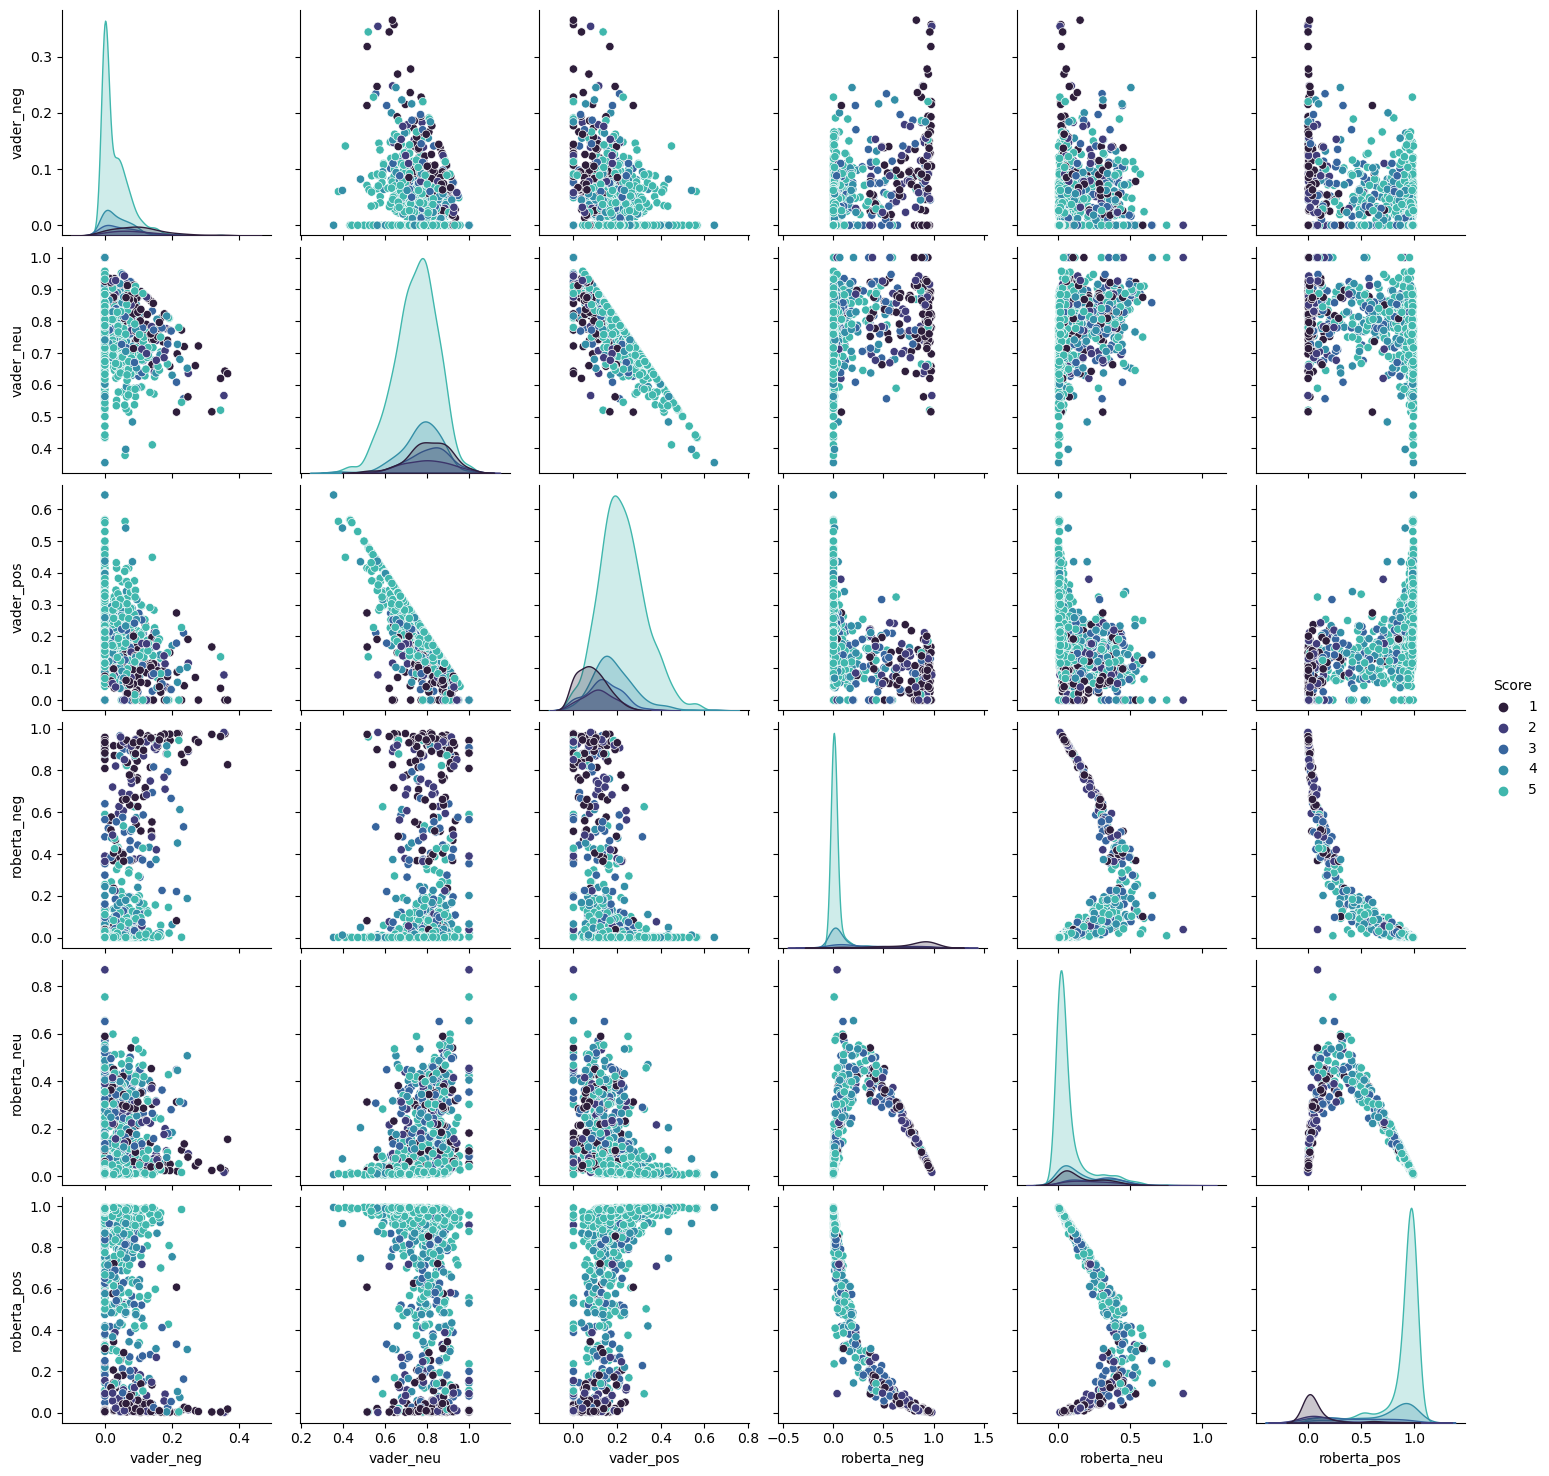

In [86]:
cols = ['vader_neg', 'vader_neu', 'vader_pos',
       'roberta_neg', 'roberta_neu', 'roberta_pos']
sns.pairplot(data=results_df,
             vars=cols,
             hue='Score',
             palette=color_pal[:5])

# Reviewing Examples

We can look at some specific examples of reviews with extreme sentiment to try and gain some insight into the limitations of the models.

In [87]:
# Showing the 1 star review with the highest positive polarity according to each model
roberta_result = results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]
vader_result = results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]
print(f"1 Star Review with Highest Positive Polarity (VADER):\n\n {vader_result}")
print("\n------------------------------------------------------------------------------\n")
print(f"1 Star Review with Highest Positive Polarity (RoBERTa):\n\n {roberta_result}\n\n")

1 Star Review with Highest Positive Polarity (VADER):

 So we cancelled the order.  It was cancelled without any problem.  That is a positive note...

------------------------------------------------------------------------------

1 Star Review with Highest Positive Polarity (RoBERTa):

 I just wanted to post here that I found small bits of plastic in this food as I was feeding my 9 month old.  Plastic!!! in food!!!! baby food!!!  So please be careful if you buy this or are considering it.My daughter LOVES this food-- it's actually her favorite.  This is the first time we have noticed plastic in it in over 2 months.




In [88]:
# Showing the 5 star review with the highest negative polarity according to each model
roberta_result = results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]
vader_result = results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]
print(f"5 Star Review with Highest Negative Polarity (VADER):\n\n {vader_result}")
print("\n------------------------------------------------------------------------------\n")
print(f"5 Star Review with Highest Negative Polarity (RoBERTa):\n\n {roberta_result}\n\n")

5 Star Review with Highest Negative Polarity (VADER):

 this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault

------------------------------------------------------------------------------

5 Star Review with Highest Negative Polarity (RoBERTa):

 this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault




In [89]:
# Showing the 1 star review with the highest negative polarity according to each model
roberta_result = results_df.query('Score == 1') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]
vader_result = results_df.query('Score == 1') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]
print(f"1 Star Review with Highest Negative Polarity (VADER):\n\n {vader_result}")
print("\n------------------------------------------------------------------------------\n")
print(f"1 Star Review with Highest Negative Polarity (RoBERTa):\n\n {roberta_result}\n\n")

1 Star Review with Highest Negative Polarity (VADER):

 The laddoos turned bad in a few days after we received it. No other item inside our fridge turned bad.

------------------------------------------------------------------------------

1 Star Review with Highest Negative Polarity (RoBERTa):

 I so wish I would have read this review before purchasing TWO gallons of this oil for my health issues. It reeks like a chemical rubber smell. This smell is coming from the black rubber gasket in the lid. When I called to report the situation to the company, Sabrina told me I would have to pay to send them a sample to have tested by a lab. Unbelievable. Good customer service would indicate that they would pay for the product to be returned and give me a full refund, including shipping. The product is faulty. Period. I will never order anything from this company again and do not recommend it to anyone based on this horrible customer service and lack of responsibility and ownership.




In [90]:
# Showing the 5 star review with the highest positive polarity according to each model
roberta_result = results_df.query('Score == 5') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]
vader_result = results_df.query('Score == 5') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]
print(f"5 Star Review with Highest Positive Polarity (VADER):\n\n {vader_result}")
print("\n------------------------------------------------------------------------------\n")
print(f"5 Star Review with Highest Positive Polarity (RoBERTa):\n\n {roberta_result}\n\n")

5 Star Review with Highest Positive Polarity (VADER):

 This is an great product. The taste is great, and it works exactly as described. Superb natural sleep aid. AMAZING!

------------------------------------------------------------------------------

5 Star Review with Highest Positive Polarity (RoBERTa):

 This is my son's favorite dinner! Best of all it seems it has the best combo of protein (21%) , vitamin A (100%) and C (30%). It is runnier than most of their dinners which was a great start for solids with protein in it. Love love love this brand and flavor. I think I purchased 50 jars so far.


